# output verification

Date: 4 May, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is on the order of 50TB of float data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#more plotting
import matplotlib.dates as mdates
from dask.distributed import Client, LocalCluster
import gc
import sys
import subprocess
from tabulate import tabulate

# functions


In [2]:
def get_package_version(package):
    # Command to get package version using pip
    command = [sys.executable, '-m', 'pip', 'show', package]
    try:
        # Run the command and capture the output
        result = subprocess.run(command, stdout=subprocess.PIPE, text=True, check=True)
        # Parse the result to find the version line
        for line in result.stdout.split('\n'):
            if 'Version:' in line:
                return line.split(': ')[1].strip()
    except subprocess.CalledProcessError:
        # Return None if the package is not found
        return None
        
def version_table(packages = None ):
    if packages is None:
        packages = []
    # Now you can safely modify list as needed
    packages.extend(['numpy', 'xarray','dask','scipy','numba','numbagg','flox','bottleneck'])
    # Prepare data for tabulation
    table = []
    for package in packages:
        version = get_package_version(package)
        if version is None:
            version = "Not installed"
        table.append([package, version])
    
    # Adjust the table to fit a max of 4 records per column set
    max_rows = 4
    num_columns = (len(table) + max_rows - 1) // max_rows  # Calculate number of columns needed
    multi_column_table = []
    
    for i in range(max_rows):
        row = []
        for j in range(num_columns):
            index = j * max_rows + i
            if index < len(table):
                row.extend(table[index])
            else:
                row.extend(['', ''])  # Fill empty spaces if no more packages
        multi_column_table.append(row)

    # Define headers for the multi-column table
    headers = []
    for i in range(num_columns):
        headers.extend(['Package', 'Version'])

    # Print the table using tabulate
    print(tabulate(multi_column_table, headers=headers, tablefmt='grid'))

In [3]:
version_table()

+-----------+-----------+------------+-----------+
| Package   | Version   | Package    | Version   |
+===========+===========+============+===========+
| numpy     | 1.26.4    | numba      | 0.59.1    |
+-----------+-----------+------------+-----------+
| xarray    | 2024.3.0  | numbagg    | 0.8.1     |
+-----------+-----------+------------+-----------+
| dask      | 2024.4.0  | flox       | 0.9.6     |
+-----------+-----------+------------+-----------+
| scipy     | 1.12.0    | bottleneck | 1.3.8     |
+-----------+-----------+------------+-----------+


#### start a local Dask client

In [4]:
cluster = LocalCluster(
    n_workers=28,          # Number of workers
    threads_per_worker=1 # Number of threads per each worker
)
client = Client(cluster)

# inspecting the draft results

In [5]:
results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/draft_delivery/'
temp_stats_file = results_path+'BRAN2020_stats_monthclim_temp.nc'
salt_stats_file = results_path+'BRAN2020_stats_monthclim_salt.nc'
u_stats_file = results_path+'/safe/BRAN2020_stats_monthclim_u.nc'
v_stats_file = results_path+'/safe/BRAN2020_stats_monthclim_v.nc'

In [6]:
stats_dataset = xr.open_dataset(v_stats_file,chunks={})

In [7]:
stats_dataset

<xarray.Dataset> Size: 53GB
Dimensions:   (month: 12, st_ocean: 51, yu_ocean: 1500, xu_ocean: 3600)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB 0.1 0.2 0.3 0.4 ... 359.8 359.9 360.0
  * yu_ocean  (yu_ocean) float64 12kB -74.9 -74.8 -74.7 -74.6 ... 74.8 74.9 75.0
  * st_ocean  (st_ocean) float64 408B 2.5 7.5 12.5 ... 3.603e+03 4.509e+03
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mean_v    (month, st_ocean, yu_ocean, xu_ocean) float32 13GB dask.array<chunksize=(12, 51, 1500, 3600), meta=np.ndarray>
    std_v     (month, st_ocean, yu_ocean, xu_ocean) float32 13GB dask.array<chunksize=(12, 51, 1500, 3600), meta=np.ndarray>
    max_v     (month, st_ocean, yu_ocean, xu_ocean) float32 13GB dask.array<chunksize=(12, 51, 1500, 3600), meta=np.ndarray>
    min_v     (month, st_ocean, yu_ocean, xu_ocean) float32 13GB dask.array<chunksize=(12, 51, 1500, 3600), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    grid_type:                       regular
    grid_tile:                       N/A
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    title:                           BRAN2020
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:domain:         ocean
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       v
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          ocean.daily

In [8]:
stats_dataset.nbytes/1e9

52.876841304

# plot

In [11]:
stats_equator_march = stats_dataset.isel(month=2).sel(yu_ocean=0,method='nearest')

In [12]:
# Define a dictionary to map variable names to colors
color_dict = {
    'mean_v': 'black',
    'min_v': 'navy',
    'max_v': 'red',
    'std_v': 'lightgrey',
    'median_v':'darkgrey',
    'quantile_05_v':'lightblue' ,
    'quantile_95_v': 'orange'
}

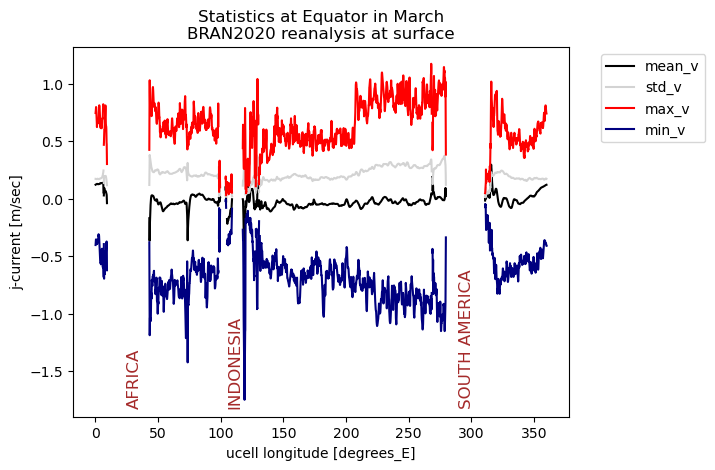

In [13]:
# Get the list of variables in the dataset
variables = list(stats_equator_march.data_vars)
#variables = ['max_temp', 'quantile_95_temp', 'median_temp', 'std_temp', 'mean_temp', 'quantile_05_temp', 'min_temp']

# Plot line for each variable
for variable in variables:
    color = color_dict.get(variable, 'black')  # Use 'black' as default color if variable is not in the dictionary
    stats_equator_march[variable].sel(st_ocean=0,method='nearest').plot.line(x='xu_ocean', 
                                                                                    label=variable, color=color)

# Add text to a specific location
plt.text(25, -1.8, 'AFRICA', fontsize=12, color='brown', rotation=90)
plt.text(105, -1.8, 'INDONESIA', fontsize=12, color='brown', rotation=90)
plt.text(290, -1.8, 'SOUTH AMERICA', fontsize=12, color='brown', rotation=90)

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Add title
plt.title('Statistics at Equator in March\nBRAN2020 reanalysis at surface')
# Set the background color to black
#plt.gca().set_facecolor('lightgrey')

# Save the plot as PNG
#plt.savefig(plot_directory+'Temp-Statistics-at-Equator-surface-in-March.png', dpi=300,bbox_inches='tight')
# Show the plot
plt.show()


### try recompressing

In [16]:
def compress_nc(ds,out_path,compression_level=4):
    compression_opts = {
        'zlib': True,        # Enable zlib compression
        'complevel': compression_level,      # Compression level (1-9)
    }

    # Set the encoding for each variable
    encoding = {var: compression_opts for var in ds.data_vars}

    # Write the dataset to a new NetCDF file with compression
    ds.to_netcdf(out_path, encoding=encoding)

In [18]:
%%time
compress_nc(mld_stats_dataset,'/g/data/es60/users/thomas_moore/clim_demo_results/daily/draft_delivery/why_so_big/out.nc',compression_level=1)

CPU times: user 33.4 s, sys: 3.24 s, total: 36.7 s
Wall time: 2min 45s


In [13]:
out_data = xr.open_dataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/draft_delivery/why_so_big/out.nc',chunks={})
out_data

<xarray.Dataset> Size: 7GB
Dimensions:                  (month: 12, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * xt_ocean                 (xt_ocean) float64 29kB 0.05 0.15 ... 359.9 360.0
  * yt_ocean                 (yt_ocean) float64 12kB -74.95 -74.85 ... 74.95
  * month                    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/28)
    mean_mld                 (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    min_mld                  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    max_mld                  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    std_mld                  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    median_mld               (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    quantile_05_mld          (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    ...                       ...
    min_neutral_mld          (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    max_neutral_mld          (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    std_neutral_mld          (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    median_neutral_mld       (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    quantile_05_neutral_mld  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
    quantile_95_neutral_mld  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(4, 500, 1200), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       mld
    intake_esm_dataset_key:          ocean.daily
    intake_esm_vars:                 mld
    title:                           BRAN2020

In [14]:
out_data.nbytes/1e9

7.257640896

In [10]:
max_mld = mld_stats_dataset[['max_mld','max_el_nino_mld','max_la_nina_mld']]
max_mld

<xarray.Dataset> Size: 778MB
Dimensions:          (month: 12, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * xt_ocean         (xt_ocean) float64 29kB 0.05 0.15 0.25 ... 359.9 360.0
  * yt_ocean         (yt_ocean) float64 12kB -74.95 -74.85 ... 74.85 74.95
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    max_mld          (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(12, 1500, 3600), meta=np.ndarray>
    max_el_nino_mld  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(12, 1500, 3600), meta=np.ndarray>
    max_la_nina_mld  (month, yt_ocean, xt_ocean) float32 259MB dask.array<chunksize=(12, 1500, 3600), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       mld
    intake_esm_dataset_key:          ocean.daily
    intake_esm_vars:                 mld
    title:                           BRAN2020

In [12]:
sel_dict = {'month':0}

In [14]:
data = max_mld.sel(sel_dict,method='nearest')
data

<xarray.Dataset> Size: 65MB
Dimensions:          (yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * xt_ocean         (xt_ocean) float64 29kB 0.05 0.15 0.25 ... 359.9 360.0
  * yt_ocean         (yt_ocean) float64 12kB -74.95 -74.85 ... 74.85 74.95
    month            int64 8B 1
Data variables:
    max_mld          (yt_ocean, xt_ocean) float32 22MB dask.array<chunksize=(1500, 3600), meta=np.ndarray>
    max_el_nino_mld  (yt_ocean, xt_ocean) float32 22MB dask.array<chunksize=(1500, 3600), meta=np.ndarray>
    max_la_nina_mld  (yt_ocean, xt_ocean) float32 22MB dask.array<chunksize=(1500, 3600), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       mld
    intake_esm_dataset_key:          ocean.daily
    intake_esm_vars:                 mld
    title:                           BRAN2020

In [26]:
diff = data.max_la_nina_mld - data.max_mld
diff

<xarray.DataArray (yt_ocean: 1500, xt_ocean: 3600)> Size: 22MB
dask.array<sub, shape=(1500, 3600), dtype=float32, chunksize=(1500, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
    month     int64 8B 1

In [19]:
diff.min().values

array(-3912.6755, dtype=float32)

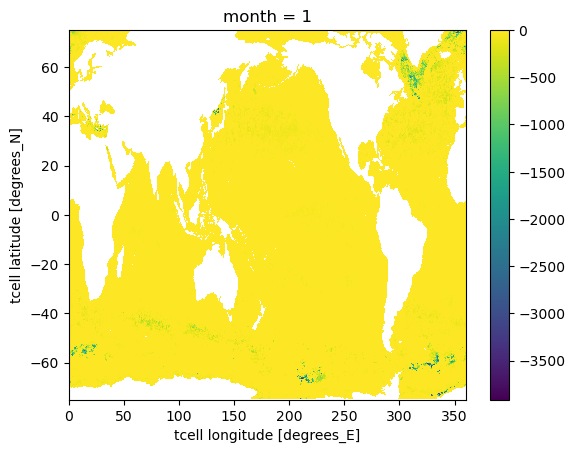

In [28]:
diff.plot()

# where are the zarr collections:

In [5]:
zarr_path = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/'
temp_chunk4time_zarr = 'BRAN2020-daily-temp-chunk4time-v07022024.zarr'

In [6]:
temp_chunk4time = xr.open_zarr(zarr_path+temp_chunk4time_zarr,consolidated=True)

In [7]:
temp_chunk4time

<xarray.Dataset> Size: 12TB
Dimensions:   (Time: 11138, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * Time      (Time) datetime64[ns] 89kB 1993-01-01T12:00:00 ... 2023-06-30T1...
  * st_ocean  (st_ocean) float64 408B 2.5 7.5 12.5 ... 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Data variables:
    temp      (Time, st_ocean, yt_ocean, xt_ocean) float32 12TB dask.array<chunksize=(11138, 51, 100, 1), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    daily
    intake_esm_attrs:variable:       temp
    intake_esm_dataset_key:          ocean.daily
    intake_esm_vars:                 ['temp']
    title:                           BRAN2020

In [8]:
%%time
equator_over_time = temp_chunk4time.temp.sel({'yt_ocean':0},method='nearest')

CPU times: user 14 ms, sys: 3.65 ms, total: 17.6 ms
Wall time: 16.1 ms


In [10]:
%%time
equator_over_time = equator_over_time.compute()

CPU times: user 1min 13s, sys: 25.5 s, total: 1min 38s
Wall time: 2min 36s


In [14]:
equator_over_time.streamjoy('/g/data/es60/users/thomas_moore/clim_demo_results/plots/equator_temp.mp4',max_frames=-1,dim='Time')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42051,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: 31 minutes ago,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:35573,Total threads: 4
Dashboard: /proxy/43733/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38231,


2024-04-10 09:35:14,410 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-04-10 09:35:14,472 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-04-10 09:35:14,653 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-04-10 09:35:15,557 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_streamjoy/lib/python3.10/site-packages/matplotlib/colors.py:743: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_streamjoy/lib/python3.10/site-packages/matplotlib/colors.py:743: RuntimeWarning: invalid value encountered in cast
  xa = xa.astype(int)
2024-04-10 09:35:17,200 - distributed.utils_perf - WARNING - full garbage collections took 18% C

PosixPath('/g/data/es60/users/thomas_moore/clim_demo_results/plots/equator_temp.mp4')

In [ ]:
_slice_.plot()

In [ ]:
%time
result = result.compute()

In [ ]:
result.plot()

# ARD workflow

### read paths from config file

#### [ you will need to specifiy your correct path for the `data-catalogue/config.ini` file ]

In [ ]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the config file
#########
#### you will need to specifiy your correct path the the `data-catalogue/config.ini` file 
#########
config.read('./code/BRAN2020-intake-catalog/config.ini')

# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')

In [ ]:
catalog_path

In [ ]:
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [ ]:
BRAN2020_catalog

In [ ]:
BRAN2020_catalog.unique()['source']

In [ ]:
BRAN2020_catalog.unique()['domain']

In [ ]:
BRAN2020_catalog.unique()['time_period']

In [ ]:
var_list = BRAN2020_catalog.unique()['variable']
var_list.sort()
df = pd.DataFrame(var_list, columns=['BRAN2020 Variables'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df)

In [ ]:
search = BRAN2020_catalog.search(variable=['mld'],time_period=['daily'])

In [ ]:
search.unique()['variable']

In [ ]:
search

In [ ]:
search.df

### Out of some 9000 files we now have narrowed down the just the 366 that have the information we need

#### We can now load all that data into a single 240GB "lazy" `xarray` object for further reduction and analysis

In [ ]:
%%time
xarray_open_kwargs = {"chunks": {"time": 1, "xt_ocean": 3600, "yt_ocean": 1500}}
DS=search.to_dask(xarray_open_kwargs=xarray_open_kwargs)

In [ ]:
DS

In [ ]:
DS.nbytes/1e9

## ARD - write zarr & chunk & write zarr

In [ ]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/'
ard_file_ID = 'BRAN2020-daily-mld-v04042024.zarr'

In [ ]:
%%time
DS.to_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)
# ----- Client(threads_per_worker=1) -------
# CPU times: user 2min 26s, sys: 29.9 s, total: 2min 56s
# Wall time: 13min 1s
# ----- Client() -------
# CPU times: user 1min 53s, sys: 18.1 s, total: 2min 11s
# Wall time: 14min 3s

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/finished_BRAN2020-mld-base-zarr.log

## RELOAD in ARD collection

In [ ]:
BRAN2020_daily_var = xr.open_zarr(BRAN2020_ard_path+ard_file_ID,consolidated=True)

In [ ]:
BRAN2020_daily_var

## CHUNK for time and WRITE zarr

### "Consider either rechunking using `chunk()`, deleting or modifying `encoding['chunks']`"

In [ ]:
def remove_zarr_encoding(DS):
    for var in DS:
        DS[var].encoding = {}

    for coord in DS.coords:
        DS[coord].encoding = {}
    return DS

In [ ]:
ard_rcTime_file_ID = 'BRAN2020-daily-mld-chunk4time-v04042024.zarr'

In [ ]:
BRAN2020_daily_var_rcTime =  BRAN2020_daily_var.chunk({'Time':-1,'xt_ocean':9,'yt_ocean':1500})
BRAN2020_daily_var_rcTime

In [ ]:
BRAN2020_daily_var_rcTime = remove_zarr_encoding(BRAN2020_daily_var_rcTime)

In [ ]:
%%time
BRAN2020_daily_var_rcTime.to_zarr(BRAN2020_ard_path+ard_rcTime_file_ID,consolidated=True)

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/finished_BRAN2020-mld-rechunk-zarr.log

# rechunker approach

In [ ]:
input_ds = BRAN2020_daily_var
target_chunks = {'Time':-1,'xt_ocean':9,'yt_ocean':1500}
max_mem = "2GB"

target_store = BRAN2020_ard_path+ard_rcTime_file_ID
temp_store = "/scratch/es60/ard/rechunker_scratch/rechunker-tmp.zarr"

# need to remove the existing stores or it won't work
!rm -rf /scratch/es60/ard/rechunker_scratch/rechunker-tmp.zarr

# rechunk directly from dataset this time
rechunk_plan = rechunk(
    input_ds, target_chunks, max_mem, target_store, temp_store=temp_store
)
rechunk_plan

In [ ]:
%%time
rechunk_plan.execute()

In [ ]:
!touch /scratch/es60/ard/reanalysis/BRAN2020/ARD/2D/finished_BRAN2020-mld-rechunker-zarr.log

In [ ]:
zarr.consolidate_metadata(target_store)

## end ARD workflow $\Uparrow$

# begin post-processing workflow $\Downarrow$

## load in zarr collection

In [ ]:
var_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
var_chunked_time

## basic functions

In [ ]:
def get_bran_monthly_climatologies(xr_object,time_coord_name = 'Time'):
    monthly_climatologies = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    result = data.groupby('time').temperature.agg(['mean', 'sum'])
    
return result



# Climatology

In [ ]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology

In [ ]:
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

In [ ]:
%%time
temp_monthly_climatology = temp_monthly_climatology.compute()

# CPU times: user 32.1 s, sys: 17.9 s, total: 49.9 s
# Wall time: 2min 20s
#

# Anomaly

In [ ]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')

In [ ]:
temp_anomaly

# define El Nino and La Nina using NCAR ONI data

In [ ]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [ ]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)
ONI_DF

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['El Nino'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI El Nino events') 
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout='constrained')
ax.plot(ONI_DF.index,ONI_DF['La Nina'])
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.title('ONI La Nina events') 
plt.show()

## heatmap

### make table for average over certain region

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_ONI_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_ONI_anomaly = spatial_mean_of_ONI_anomaly.compute()

In [ ]:
spatial_mean_of_ONI_anomaly.plot()

In [ ]:
spatial_mean_of_ONI_anomaly_DF = spatial_mean_of_ONI_anomaly.to_dataframe()
spatial_mean_of_ONI_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_ONI_anomaly_DF.index).year
spatial_mean_of_ONI_anomaly_DF

In [ ]:
heatmap_data = spatial_mean_of_ONI_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

In [ ]:
heatmap_data

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region')
plt.show()

## stacked heatmap plot

In [ ]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [ ]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

#### count of events in BRAN2020 period
El Nino = 8 events ( weak - strong ) as defined by ONI<br>
La Nina = 10 events ( weak - strong ) as defined by ONI <br>
El Nino months total = 70 = 19%
La Nina months total = 119 = 33%
Neutral months total = 171 = 48%


In [ ]:
ONI_DF_BRANtime 

# filter BRAN2020 data by ENSO

In [ ]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']
ONI_DF_BRANtime['El Nino LOGICAL'] = ONI_DF_BRANtime['El Nino'].notnull()
ONI_DF_BRANtime['La Nina LOGICAL'] = ONI_DF_BRANtime['La Nina'].notnull()
ONI_DF_BRANtime

In [ ]:
El_Nino_mask = ONI_DF_BRANtime['El Nino LOGICAL']
El_Nino_mask = El_Nino_mask.to_xarray()
El_Nino_mask = El_Nino_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
El_Nino_mask['Time'] = sync_Time

In [ ]:
La_Nina_mask = ONI_DF_BRANtime['La Nina LOGICAL']
La_Nina_mask = La_Nina_mask.to_xarray()
La_Nina_mask = La_Nina_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
La_Nina_mask['Time'] = sync_Time

In [ ]:
ONI_DF_BRANtime['Neutral LOGICAL'] = (ONI_DF_BRANtime['El Nino LOGICAL'] == False) & (ONI_DF_BRANtime['La Nina LOGICAL'] == False)

In [ ]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum()

In [ ]:
ONI_DF_BRANtime['La Nina LOGICAL'].sum()

In [ ]:
ONI_DF_BRANtime['Neutral LOGICAL'].sum()

# Test if they add to 360

In [ ]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum() + ONI_DF_BRANtime['La Nina LOGICAL'].sum()+ONI_DF_BRANtime['Neutral LOGICAL'].sum() == 360

In [ ]:
ONI_DF_BRANtime

In [ ]:
El_Nino_BRAN2020_temp = temp_chunked_time.temp.where(El_Nino_mask)
La_Nina_BRAN2020_temp = temp_chunked_time.temp.where(La_Nina_mask)

In [ ]:
%%time
El_Nino_SST_mean = El_Nino_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()
La_Nina_SST_mean = La_Nina_BRAN2020_temp.isel(st_ocean=0).mean('Time').compute()

In [ ]:
plt.figure(figsize=(16,8))
(El_Nino_SST_mean-La_Nina_SST_mean).plot()
plt.title('Mean monthly BRAN2020 SST for El Nino - La Nina events')

## El Nino "climatology"

In [ ]:
%%time
El_Nino_temp_monthly_climatology = get_monthly_climatology(El_Nino_BRAN2020_temp, time_coord_name = 'Time')
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
El_Nino_temp_monthly_climatology = El_Nino_temp_monthly_climatology.compute()


## La Nina "climatology"

In [ ]:
%%time
La_Nina_temp_monthly_climatology = get_monthly_climatology(La_Nina_BRAN2020_temp, time_coord_name = 'Time')
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
La_Nina_temp_monthly_climatology = La_Nina_temp_monthly_climatology.compute()

In [ ]:
El_Nino_temp_monthly_climatology

In [ ]:
diff_EN_LN_climatology = El_Nino_temp_monthly_climatology - La_Nina_temp_monthly_climatology

In [ ]:
diff_EN_LN_climatology

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = diff_EN_LN_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_diff_EN_LN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_diff_EN_LN = spatial_mean_diff_EN_LN.compute()

In [ ]:
spatial_mean_diff_EN_LN.plot(ylim=[0,3])

In [ ]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = El_Nino_temp_monthly_climatology.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'month':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_EN = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_EN = spatial_mean_EN.compute()
spatial_mean_EN.plot()

# Mean, Median, Max , Min

In [ ]:
El_Nino_mean = El_Nino_BRAN2020_temp.mean('Time')
El_Nino_median = El_Nino_BRAN2020_temp.median('Time')
El_Nino_max = El_Nino_BRAN2020_temp.max('Time')
El_Nino_min = El_Nino_BRAN2020_temp.min('Time')
El_Nino_std = El_Nino_BRAN2020_temp.std('Time')
El_Nino_quant = El_Nino_BRAN2020_temp.quantile([0.05,0.95],skipna=True,dim='Time')

In [ ]:
%%time
El_Nino_quant.isel(quantile=0).isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
%%time
El_Nino_quant.isel(quantile=1).isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
def get_slice(xr_object)
    max_lat = 5.0
    min_lat = -5.0
    max_lon = 240
    min_lon = 190
    LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
    SliceData = xr_object.sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})

In [ ]:
El_Nino_min.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
El_Nino_max.isel(st_ocean=0).plot(robust=True,vmin=-1,vmax=35)

In [ ]:
diff = El_Nino_max.isel(st_ocean=0) - El_Nino_min.isel(st_ocean=0) 
diff.plot(robust=True)

In [ ]:
El_Nino_std.isel(st_ocean=0).plot(robust=True)

# The End

In [ ]:
client.shutdown()

## Plot current vectors for August

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline 

In [ ]:
%%time
# Define the u and v components of the currents
time_choice = 8
u = clim_uv.u.sel(month=time_choice)
v = clim_uv.v.sel(month=time_choice)
speed = np.sqrt(u**2 + v**2)

In [ ]:
#plot model data
transform = ccrs.PlateCarree()
cmap = 'Spectral_r'
cbar_label='current speed'
plot_data = speed

###
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = plt.subplot(projection=ccrs.PlateCarree(180))
ax.set_extent([142,160, -25, -10], ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='white'))
ax.coastlines('50m',linewidth=0.5,edgecolor='grey')
plot_data.plot(transform=transform,cmap=cmap,cbar_kwargs={'label': cbar_label,'shrink':0.5},robust=True)

#plot u/v vectors
# Define the x and y coordinates
x = clim_uv.xu_ocean
y = clim_uv.yu_ocean
ax.quiver(x.values,y.values,u.values,v.values,transform=transform, units='x', width=0.01, scale=0.7, headwidth=2,alpha=0.2)
ax.set_title('BRAN2020 1993-2022\ncurrent speed \n August Climatology')